In [5]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [6]:
#load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Quick debug of the target in raw
print("\retention_statu distribution:")
print(train["retention_status"].value_counts())

Train shape: (59611, 24)
Test shape: (14900, 23)
etention_statu distribution:
retention_status
Stayed    31265
Left      28346
Name: count, dtype: int64


In [7]:
#data info
print("\nTrain Head:")
train.head()


Train Head:


,founder_id,founder_age,founder_gender,years_with_startup,founder_role,monthly_revenue_generated,work_life_balance_rating,venture_satisfaction,startup_performance_rating,funding_rounds_led,...,num_dependents,startup_stage,team_size_category,years_since_founding,remote_operations,leadership_scope,innovation_support,startup_reputation,founder_visibility,retention_status
0,8410,31,Male,19,Education,5390.0,Excellent,Medium,Average,2,...,0.0,Mid,Medium,89.0,No,No,No,Excellent,Medium,Stayed
1,64756,59,Female,4,Media,5534.0,Poor,High,Low,3,...,3.0,Mid,Medium,21.0,No,No,No,Fair,Low,Stayed
2,30257,24,Female,10,Healthcare,8159.0,Good,High,Low,0,...,3.0,Mid,Medium,74.0,No,No,No,Poor,Low,Stayed
3,65791,36,Female,7,Education,3989.0,Good,High,High,1,...,2.0,Mid,Small,50.0,Yes,No,No,Good,Medium,Stayed
4,65026,56,Male,41,Education,4821.0,NaN,NaN,Average,0,...,0.0,Senior,Medium,68.0,No,No,No,Fair,Medium,Stayed


In [8]:
#check for negatives in training data
numeric_cols=train.select_dtypes('number').columns.tolist()
print("\nAny negative numeric values per column:")
print((train[numeric_cols]<0).any())


Any negative numeric values per column:
founder_id                    False
founder_age                   False
years_with_startup            False
monthly_revenue_generated     False
funding_rounds_led            False
distance_from_investor_hub    False
num_dependents                False
years_since_founding          False
dtype: bool


In [9]:
#check for duplicates
dup_count = train.duplicated().sum()
print(f"\nNumber of duplicate rows in train: {dup_count}")

if dup_count > 0:
    train.drop_duplicates(inplace=True)
    print("Duplicates removed. New shape:", train.shape)


Number of duplicate rows in train: 13
Duplicates removed. New shape: (59598, 24)


In [10]:
#check for missing vals
print("\nMissing Values in Train Dataset:")
print(train.isnull().sum())


Missing Values in Train Dataset:
founder_id                        0
founder_age                       0
founder_gender                    0
years_with_startup                0
founder_role                      0
monthly_revenue_generated      1787
work_life_balance_rating      10131
venture_satisfaction           7151
startup_performance_rating        0
funding_rounds_led                0
working_overtime                  0
distance_from_investor_hub        0
education_background              0
personal_status                   0
num_dependents                 4767
startup_stage                     0
team_size_category             2979
years_since_founding           4171
remote_operations                 0
leadership_scope                  0
innovation_support                0
startup_reputation                0
founder_visibility                0
retention_status                  0
dtype: int64


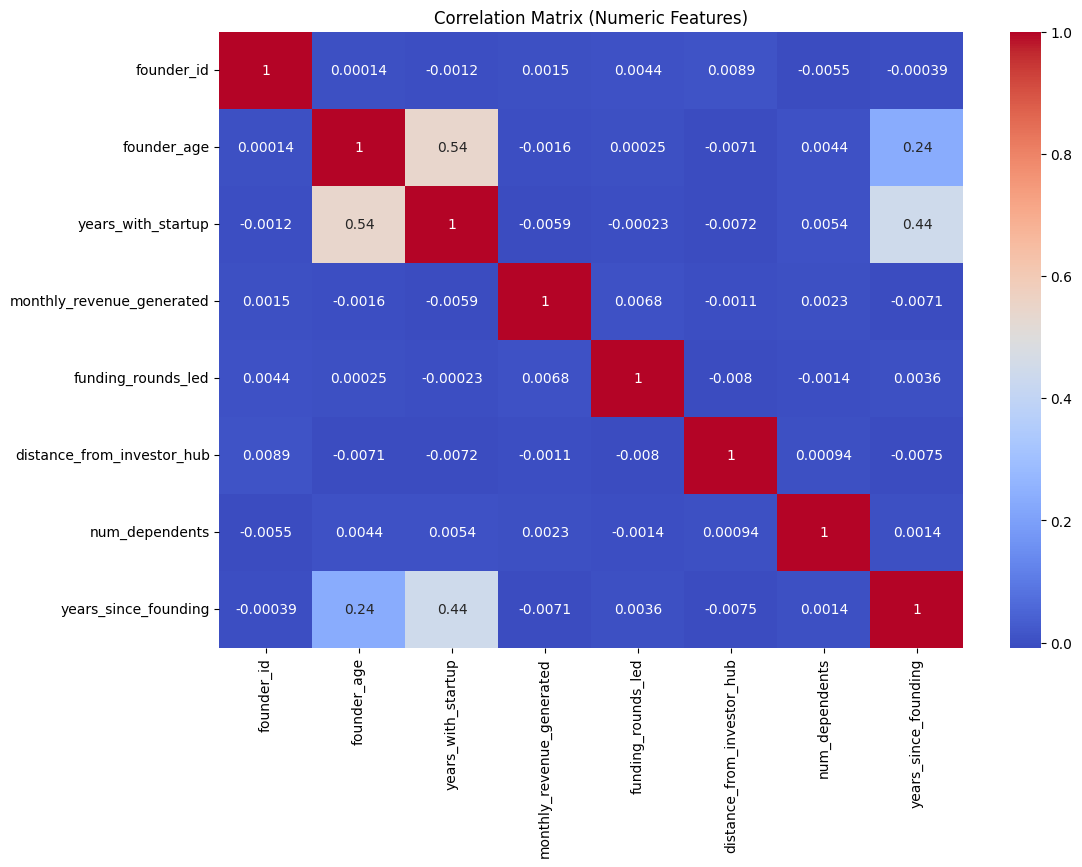

In [11]:
# Correlation Matrix
numeric_features = train.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(12,8))
sns.heatmap(train[numeric_features].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

In [12]:
# Feature Engineering (applied before plotting/splitting)
for df in [train, test]:
    df['experience_ratio'] = df['years_with_startup'] / (df['years_since_founding'] + np.finfo(float).eps)
    df['founder_join_age'] = df['founder_age'] - df['years_with_startup']
    df['revenue_per_round'] = df['monthly_revenue_generated'] / (df['funding_rounds_led'] + 1)

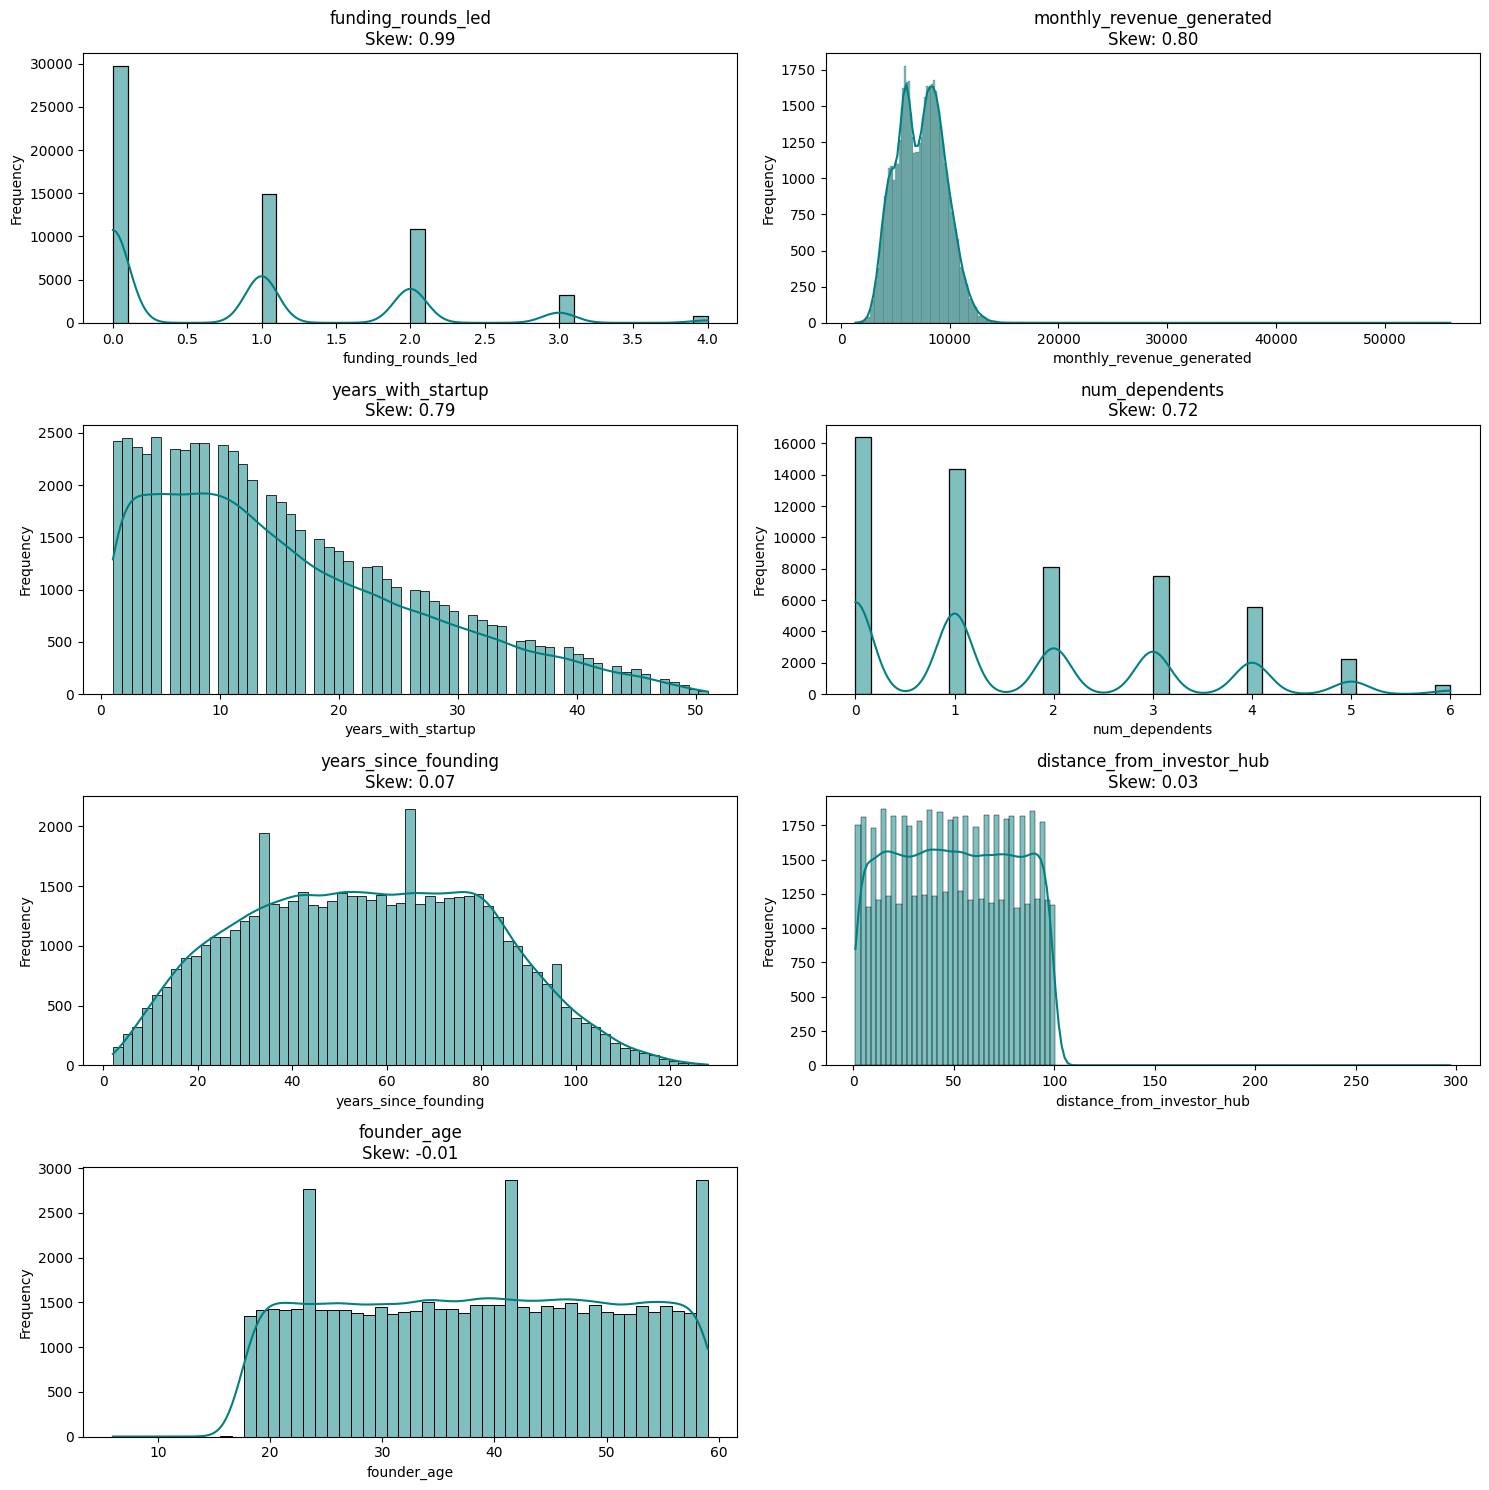

In [13]:
# Feature Distributions (Histograms)
num_cols_for_histogram = ['founder_age', 'years_with_startup', 'monthly_revenue_generated', 'distance_from_investor_hub', 'years_since_founding', 'num_dependents', 'funding_rounds_led']
skew_values = train[num_cols_for_histogram].skew().sort_values(ascending=False)
sorted_cols = skew_values.index.tolist()

plt.figure(figsize=(15,15))
for i, col in enumerate(sorted_cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(train[col].dropna(), kde=True, bins='auto', color='teal')
    plt.title(f'{col}\nSkew: {skew_values[col]:.2f}', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)

plt.tight_layout()
plt.show()

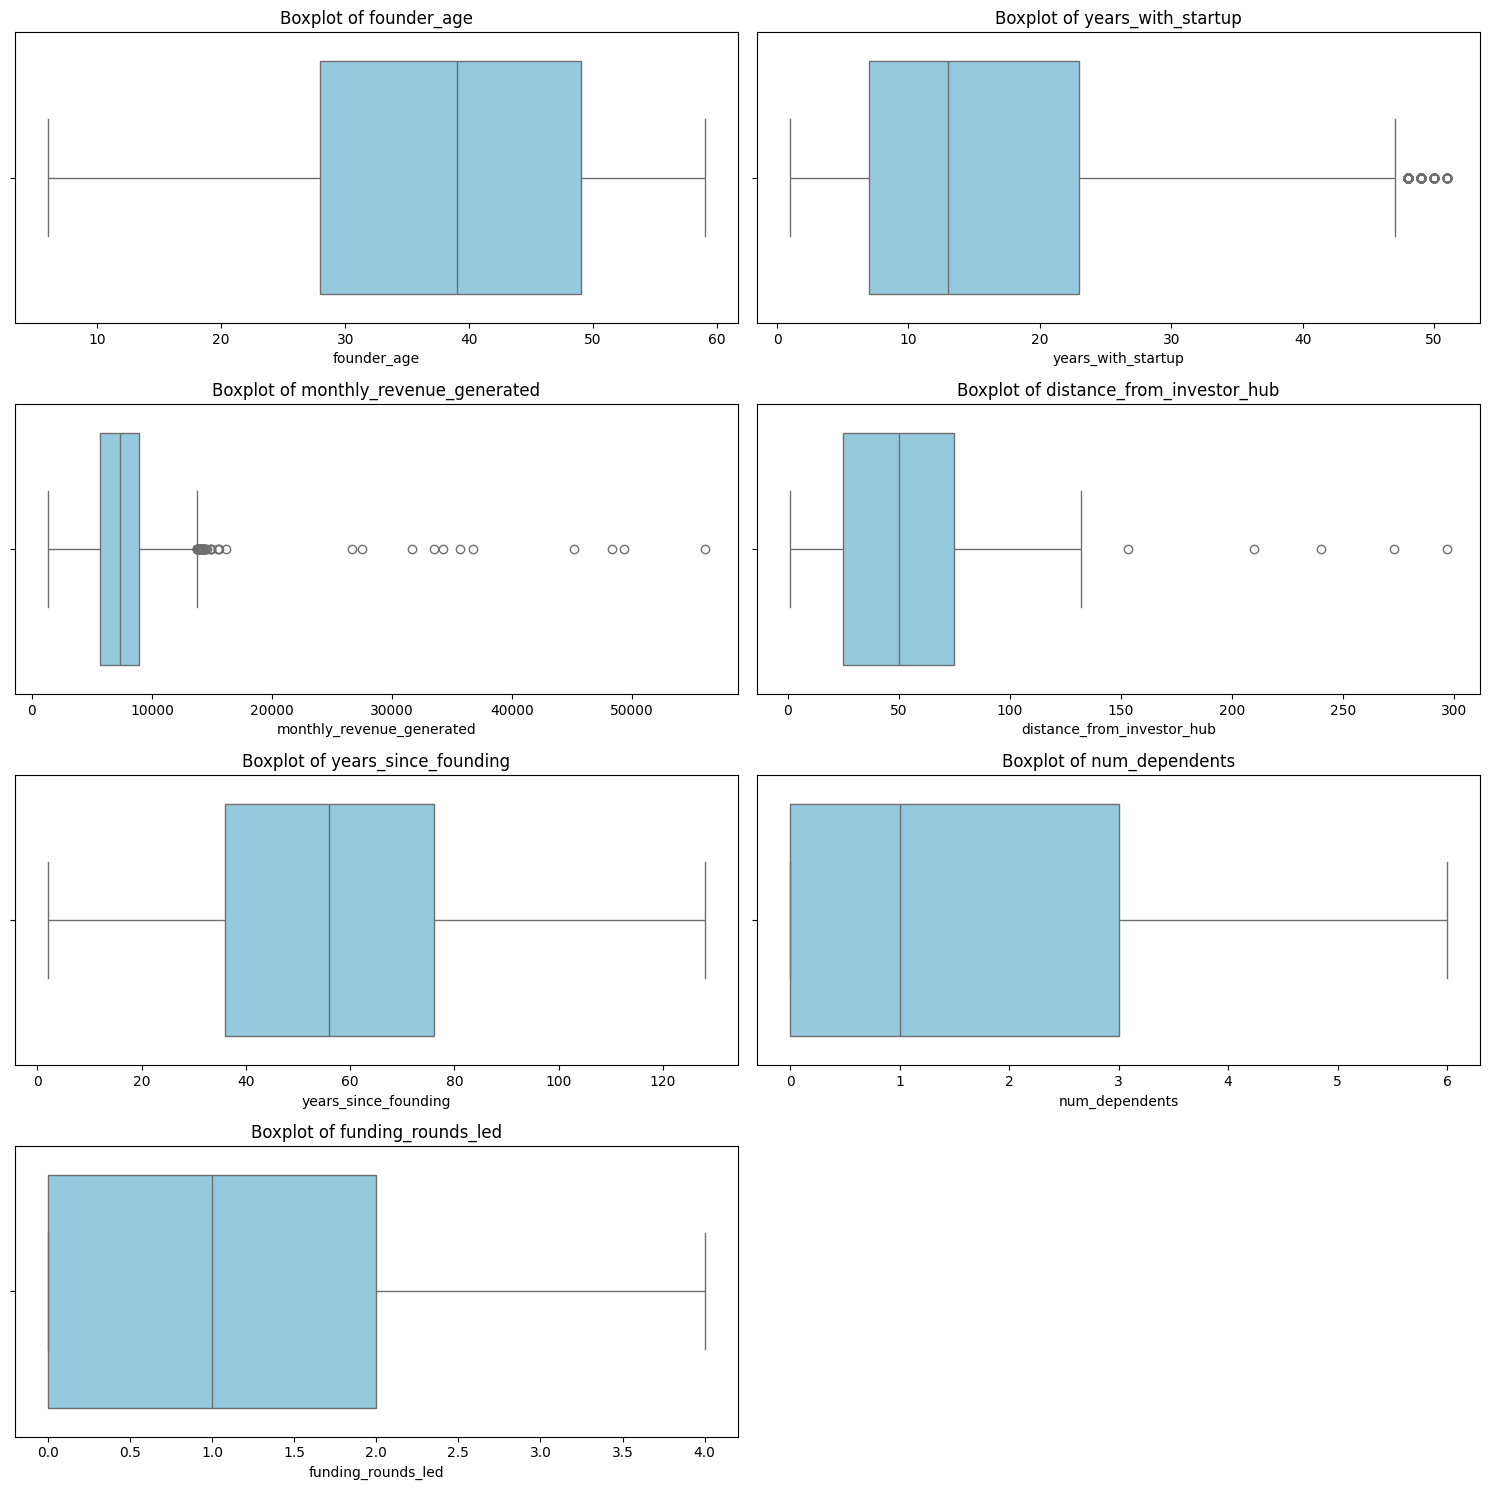

In [14]:
# Box plots for Outlier Detection
num_cols_for_boxplot = ['founder_age', 'years_with_startup', 'monthly_revenue_generated', 'distance_from_investor_hub', 'years_since_founding', 'num_dependents', 'funding_rounds_led']

plt.figure(figsize=(15, 15))
for i, col in enumerate(num_cols_for_boxplot, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(data=train, x=col, color='skyblue')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [15]:
# Separate Features (X) and Target (y)
X = train.drop(columns=['retention_status', 'founder_id'])
y = train['retention_status'].map({'Stayed': 1, 'Left': 0})

# Prepare the final test set for submission prediction
X_test_final = test.drop(columns=['founder_id'])

# Split the Data (80% Train, 20% Test, stratified)
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set shape: {X_train.shape}, Validation set shape: {X_test_val.shape}")


Training set shape: (47678, 25), Validation set shape: (11920, 25)


In [16]:
# Define column types
numerical_cols = [
    'monthly_revenue_generated', 'num_dependents', 'years_since_founding',
    'founder_age', 'years_with_startup', 'funding_rounds_led',
    'distance_from_investor_hub', 'experience_ratio',
    'founder_join_age', 'revenue_per_round'
]

binary_cols = ['working_overtime', 'remote_operations', 'leadership_scope', 'innovation_support']

# Define the order for ordinal features
ordinal_cols = {
    'work_life_balance_rating': ['Poor', 'Fair', 'Good', 'Excellent'],
    'venture_satisfaction': ['Low', 'Medium', 'High', 'Very High'],
    'startup_performance_rating': ['Low', 'Below Average', 'Average', 'High'],
    'startup_reputation': ['Poor', 'Fair', 'Good', 'Excellent'],
    'founder_visibility': ['Low', 'Medium', 'High', 'Very High'],
    'startup_stage': ['Entry', 'Mid', 'Senior'],
    'team_size_category': ['Small', 'Medium', 'Large']
}
ordinal_feature_names = list(ordinal_cols.keys())
ordinal_categories = list(ordinal_cols.values())

nominal_cols = ['founder_gender', 'founder_role', 'education_background', 'personal_status']

In [17]:
# Create Preprocessing Pipelines
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()) 
])

# Binary Pipeline: Impute with Mode, then map 'No'->0, 'Yes'->1
binary_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('mapper', OrdinalEncoder(categories=[['No', 'Yes']] * len(binary_cols)))
])

# Ordinal Pipeline: Impute with Mode, then encode based on defined order
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(categories=ordinal_categories))
])

# Nominal Pipeline: Impute with Mode, then One-Hot Encode
nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

In [18]:
# Combine all transformations into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('bin', binary_pipeline, binary_cols),
        ('ord', ordinal_pipeline, ordinal_feature_names),
        ('nom', nominal_pipeline, nominal_cols)
    ],
    remainder='drop' 
)

print("\n--- Preprocessor Defined ---")


--- Preprocessor Defined ---


In [19]:
#Fit and Transform Data 

X_train_processed = preprocessor.fit_transform(X_train)
X_test_val_processed = preprocessor.transform(X_test_val)
X_test_final_processed = preprocessor.transform(X_test_final)

In [20]:
# Convert Processed Data to DataFrame (Optional, for inspection/feature selection)
# Generate feature names
nominal_feature_names_out = preprocessor.named_transformers_['nom']['onehot'].get_feature_names_out(nominal_cols)
all_feature_names = (numerical_cols +
                     binary_cols +
                     ordinal_feature_names +
                     list(nominal_feature_names_out))

# Convert to DataFrames
X_train_df = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_test_val_df = pd.DataFrame(X_test_val_processed, columns=all_feature_names)
X_test_final_df = pd.DataFrame(X_test_final_processed, columns=all_feature_names)


print("\n--- Final Processed Data Shapes ---")
print(f"X_train (ready for model): {X_train_df.shape}")
print(f"X_test_val (ready for evaluation): {X_test_val_df.shape}")
print(f"X_test_final (ready for submission prediction): {X_test_final_df.shape}")

print("\nProcessed Training Data Head (Standardized & Encoded):")
print(X_train_df.head())


--- Final Processed Data Shapes ---
X_train (ready for model): (47678, 32)
X_test_val (ready for evaluation): (11920, 32)
X_test_final (ready for submission prediction): (14900, 32)

Processed Training Data Head (Standardized & Encoded):
   monthly_revenue_generated  num_dependents  years_since_founding  \
0                  -1.051940        1.000000              0.351351   
1                  -0.905098        0.000000              0.000000   
2                   0.829112        0.666667              1.243243   
3                  -0.739019        1.333333              0.486486   
4                  -0.910548        0.333333              0.162162   

   founder_age  years_with_startup  funding_rounds_led  \
0     0.809524              1.5625                -0.5   
1    -0.571429             -0.6875                -0.5   
2     0.571429              1.4375                 2.5   
3     0.238095              1.0625                -0.5   
4    -0.285714              0.3750                